# Poisson Processes

Here's a [question from the Reddit statistics forum](https://www.reddit.com/r/statistics/comments/i9t1fq/q_poisson_process_vs_poisson_distribution/).

> I am hoping someone can give me a layman's explanation of the difference between the Poisson Process and the Poisson Distribution. I've read a couple different articles across Wikipedia, StackExchange, Statisticshowto, etc, but it's not quite sinking in.
>
> As best I understand it (in layman), the Poisson Process is a sampling of "success" data points over a period of time (eg, the number of ships that dock at a port in a given hour), and the Poisson Distribution is one of a few distribution functions whose shape may or may not represent the data collected from the process. Would this be correct to say?

This is a good question, and OP did a pretty good job answering it.
Continuing their example, suppose you are a ship spotter -- that is, someone whose hobby is to observe and identify ships.
You might be interested in the number of ships that arrive during an interval in time, or the time between arrivals, or other related questions.

A **Poisson process** is a model used to describe situations like this.
In the model, an event like the arrival of a ship is treated as an instantaneous point in time -- and it's considered to be random, with some probability of occurring at any instant.
In the simplest version of a Poisson process, that probability is constant, so it doesn't depend on time, the number of previous events, or the time since a previous event.
Under that assumption, the number of events that happen in an interval of time follows a **Poisson distribution**, and the time between events follows an exponential distribution.

Of course, the real world is more complicated than that.
Ships might be more likely to arrive during the day, or at certain times of day.
There might be a minimum time between arrivals, to avoid traffic.
Or there might be a maximum capacity at the harbor, limiting the number of arrivals.

But the Poisson process can be a useful model even if its assumptions are not strictly true.
To demonstrate, let's consider another system that involves events that occur over time, goal-scoring in hockey.

[Click here to run this notebook on Colab](https://colab.research.google.com/github/AllenDowney/DataQnA/blob/main/nb/poisson_process.ipynb).

I'll download a utilities module with some of my frequently-used functions, and then import the usual libraries.

In [1]:
from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + str(local))
    return filename

download('https://github.com/AllenDowney/DataQnA/raw/main/nb/utils.py');

In [2]:
# install the empiricaldist library, if necessary

try:
    import empiricaldist
except ImportError:
    !pip install empiricaldist

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from utils import decorate

## How Poisson is Hockey?

From HockeyReference, I downloaded results of every game of the National Hockey League (NHL) 2023-2024 regular season (not including the playoffs).
I extracted information about goals scored during 60 minutes of regulation play, not including overtime or tie-breaking shootouts.

Raw data downloaded from <https://www.hockey-reference.com/leagues/NHL_2024_games.html> on July 16, 2024.

In [4]:
download("https://github.com/AllenDowney/DataQnA/raw/main/data/nhl_2023_2024.hdf");

The results are in an HDF file with one key for each game and a list of times when a goal was scored, recorded in seconds since the beginning of the game.

In [5]:
filename = "nhl_2023_2024.hdf"

with pd.HDFStore(filename, "r") as store:
    keys = store.keys()
len(keys)

1312

The following loop reads the file and collects the time in seconds, since the beginning of the game, for each of 7896 goals.

In [6]:
all_times = []

for key in keys:
    times = pd.read_hdf(filename, key=key)
    all_times.extend(times)
    
len(all_times)

7896

If the Poisson assumptions are strictly true, and the probability of a goal is the same at any time, we expect the same number of goals during each minute of the game.
To see if that's true, let's look at the PMF of goal times rounded off to minutes.

In [7]:
from empiricaldist import Pmf

minutes = np.array(all_times) // 60 + 0.5
pmf_minutes = Pmf.from_seq(minutes)

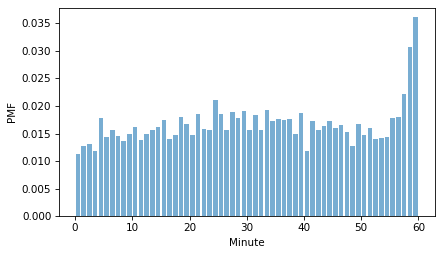

In [8]:
pmf_minutes.bar(alpha=0.6)
decorate(xlabel="Minute", ylabel="PMF")
plt.savefig('poisson_process1.png', dpi=300)

The most notable feature is that more goals are scored in the last few minutes of the game.
If you are familiar with hockey, you know that near the end of a game, a team that is losing by one or two goals often replaces their goalie with a sixth offensive player, which increases their chances of scoring, but also increases the chance that the other team scores an empty net goal.

To a lesser degree, it looks like goals are less likely during the first few minutes of the game.

## The Poisson Distribution

But even if the world violates the assumptions of the Poisson process, the predictions of the model can be remarkably accurate.
For example, a Poisson distribution fits the distribution of total goals scored with remarkable accuracy.

The following loop reads the data file and collects the number of goals scored in each game.

In [9]:
goals = []

for key in keys:
    times = pd.read_hdf(filename, key=key)
    n = len(times)
    goals.append(n)

One characteristic of a Poisson distribution is that the mean equals the variance.
Let's see if that's true for the empirical distribution of goals.

In [10]:
np.mean(goals), np.var(goals)

(6.0182926829268295, 5.45698245092207)

It's close, but the variance is a little lower than the mean.
Here's what the whole distribution looks like.

In [11]:
from empiricaldist import Pmf

pmf_goals = Pmf.from_seq(goals, name="home goals")

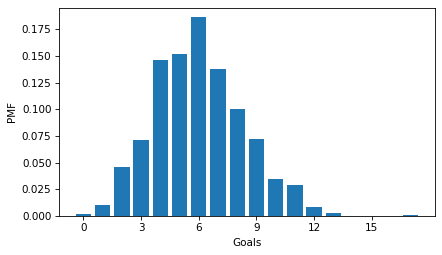

In [12]:
pmf_goals.bar()

xticks = range(0, 18, 3)
decorate(xlabel="Goals", ylabel="PMF", xticks=xticks)

To see whether it follows a Poisson distribution, we'll compare the empirical CDF to the CDF of a Poisson distribution with the same mean.

In [13]:
from scipy.stats import poisson

ks = np.arange(18)
lam = np.mean(goals)
ps = poisson.cdf(ks, lam)

In [14]:
from empiricaldist import Cdf

cdf_poisson = Cdf(ps, ks, name="Poisson model")

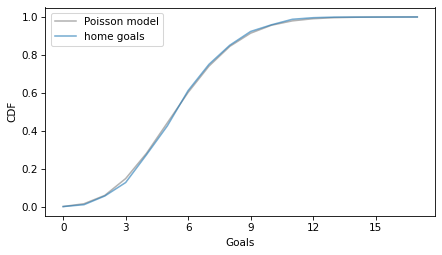

In [15]:
cdf_poisson.plot(color='gray', alpha=0.6)
pmf_goals.make_cdf().plot(alpha=0.6)

decorate(xlabel="Goals", ylabel="CDF", xticks=xticks)
plt.savefig('poisson_process2.png', dpi=300)

There might be fewer games with three goals than we expect in a Poisson distribution, but overall the  Poisson distribution fits the data well.

## Times Between Goals

Similarly, if the assumptions of the Poisson process are correct, the time between goals should follow an exponential distribution.
To see whether it does, we can extract the intervals from the data.

In [16]:
intervals = []

for key in keys:
    times = pd.read_hdf(filename, key=key)
    diffs = np.diff(times, prepend=0) / 60
    
    if len(diffs) > 0:
        intervals.extend(diffs)
    else:
        intervals.append(np.nan)

len(intervals)

7899

If there are no goals in a game, we have observed an interval that is at least 60 minutes, but we don't know how much longer it would be if the game continued.
Fortunately, this only happened three times, so this missing data doesn't affect the results much.

Here's a summary of the times between goals.

In [17]:
pd.Series(intervals).describe()

count    7896.000000
mean        8.639921
std         7.939927
min         0.066667
25%         2.783333
50%         6.275000
75%        12.050000
max        59.683333
dtype: float64

The [shortest time between goals](https://youtu.be/s7JjoVs8FfQ?t=258) is 4 seconds.
The [longest is 59 minutes 41 seconds](https://youtu.be/u_fwGuhB2PQ?t=545).
Coincidentally, the same team scored both goals.

[Two](https://youtu.be/wf5zsPMwFMk?t=12) [teams](https://youtu.be/-bjk3blqeGk?t=18) tied for the earliest goal, in 11 seconds.
In the [highest scoring game](https://youtu.be/zkdyb8a76i4) Minnesota beat Vancouver 10 to 7, including two empty net goals.

Here's the CDF of an exponential distribution with the same mean as the data (ignoring missing data).

In [18]:
lam = 1 / np.nanmean(intervals)
lam

0.11574179826343327

In [19]:
from scipy.stats import expon

ts = np.linspace(0, 60, 201)
ps = expon.cdf(ts, scale=1/lam)
cdf_model = Cdf(ps, ts, name="exponential model")

And here's how the exponential model compares to the CDF of the data.

In [20]:
cdf_intervals = Cdf.from_seq(intervals, name="data", dropna=False)

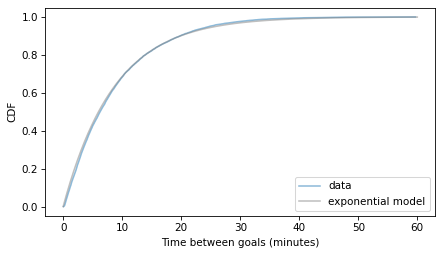

In [21]:
cdf_intervals.plot(alpha=0.5)
cdf_model.plot(color='gray', alpha=0.5)

decorate(xlabel="Time between goals (minutes)", ylabel="CDF")
plt.savefig('poisson_process3.png', dpi=300)

The exponential model is a near-perfect fit for the data.

## Correlation

Finally, if the assumptions of the Poisson process are correct, there should be no correlation between successive intervals -- that is, the expected time until the next goal does not depend on the intervals between previous goals.

To see whether that's true, we can select pairs of successive intervals.

In [22]:
pairs = []

for key in keys:
    times = pd.read_hdf(filename, key=key)
    diffs = np.diff(times, prepend=0) / 60
    
    for i in range(len(diffs) - 1):
        pair = (diffs[i], diffs[i + 1])
        pairs.append(pair)

In [23]:
first, second = np.transpose(pairs)

And compute the correlation between them.

In [25]:
np.corrcoef(first, second)[0, 1]

-0.07050687062964558

The correlation is negative, which means a short interval is more likely to be followed by a long interval.
But it is very weak, so the assumption that there is no correlation is a reasonable modeling decision.

From these results, we can see that the Poisson process is a robust model -- even when its assumptions are not strictly true, its predictions are quite good, particularly the Poisson distribution of the number of events in an interval and the exponential distribution of intervals between events.

## Discussion

Poisson processes are a common source of confusion.
One reason is the word "process", which doesn't mean much in this context.
I think "model" would be clearer.

Another reason for confusion is that it is hard to define a Poisson process in its most general form.
In the examples we've considered, events happen over time, but they could also happen over space, or any other continuous domain.

It's hard to write a definition for something so abstract -- usually the best way to understand it is to start with concrete examples.

[*Data Q&A: Answering the real questions with Python*](https://allendowney.github.io/DataQnA/index.html)

Copyright 2024 [Allen B. Downey](https://allendowney.com)

License: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/)